In [1]:
# !/usr/local/bin/pip3.9 install seaborn
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy.stats import chi2_contingency, chi2, ttest_ind, ttest_ind_from_stats, norm, binom
np.random.seed(1)

In [3]:
def calculate_n(u, t, k):
    ns = ( ((t + (k - 1)*u)/k) * (1 - (t + (k - 1)*u)/k) ) / ( (t*(1-t) )/k)**2
    return ns


def get_g_test(counts_base, counts_var, visitors_base, visitors_var):
    try:
        p_value = chi2_contingency(
            [[counts_base, counts_var], [visitors_base - counts_base, visitors_var - counts_var]], 
            correction = False, lambda_='log-likelihood'
        )[1]
    except ValueError:
        p_value = [nan]
    return p_value


def vertical_plot_lines(x, xal, yal, **kwargs):
    plt.axvline(x.mean(), linestyle = '--', color = kwargs.get("color", "g"), alpha = 0.5)
    tx_mean = "mean: {:.3f}".format(x.mean())
    txkw = dict(size=11, color = kwargs.get("color", "g"), rotation=90)
    plt.text(x.mean()+xal, yal, tx_mean, **txkw)
    

In [4]:


max_k = 10
binary_param_vals = [i/10 for i in range(1,10,2)]
k_vals = [i/100 for i in range(100,max_k*100,1)]
results = []
for u,t in product(binary_param_vals, binary_param_vals):
    for k in k_vals:
        n_vals = {
            'P_u': u,
            'P_t': t,
            'k': k,
            'n_tag': calculate_n(u, t, k=k),
            'n': calculate_n(u, t, k=1),
        }
        results.append(n_vals)
            
df = pd.DataFrame(results)
df['n_ratio'] = df['n_tag'] / df['n']
df['n_is_faster'] = (df['n_ratio'] > df['k']**2)
df

,P_u,P_t,k,n_tag,n,n_ratio,n_is_faster
0,0.1,0.1,1.00,11.111111,11.111111,1.0000,False
1,0.1,0.1,1.01,11.334444,11.111111,1.0201,False
2,0.1,0.1,1.02,11.560000,11.111111,1.0404,False
3,0.1,0.1,1.03,11.787778,11.111111,1.0609,True
4,0.1,0.1,1.04,12.017778,11.111111,1.0816,False
...,...,...,...,...,...,...,...
22495,0.9,0.9,9.95,1100.027778,11.111111,99.0025,False
22496,0.9,0.9,9.96,1102.240000,11.111111,99.2016,False
22497,0.9,0.9,9.97,1104.454444,11.111111,99.4009,True
22498,0.9,0.9,9.98,1106.671111,11.111111,99.6004,False


In [5]:
def calculate_n_cont(su, st, k):
    ns = (su*(k**2) + k*(st-su))/su
    return ns

max_k = 10
cont_param_vals = [i/10 for i in range(40,60,2)]
k_vals = [i/100 for i in range(100,max_k*100,1)]
results = []
for u,t in product(cont_param_vals, cont_param_vals):
    for k in k_vals:
        n_vals = {
            'S_u': u,
            'S_t': t,
            'k': k,
            'n_tag': calculate_n_cont(u, t, k=k),
            'n': calculate_n_cont(u, t, k=1),
        }
        results.append(n_vals)
            
df_cont = pd.DataFrame(results)
df_cont['n_ratio'] = df_cont['n_tag'] / df_cont['n']
df_cont['n_is_faster'] = (df_cont['n_ratio'] > df_cont['k']**2)
df_cont

,S_u,S_t,k,n_tag,n,n_ratio,n_is_faster
0,4.0,4.0,1.00,1.0000,1.0,1.0000,False
1,4.0,4.0,1.01,1.0201,1.0,1.0201,False
2,4.0,4.0,1.02,1.0404,1.0,1.0404,False
3,4.0,4.0,1.03,1.0609,1.0,1.0609,False
4,4.0,4.0,1.04,1.0816,1.0,1.0816,False
...,...,...,...,...,...,...,...
89995,5.8,5.8,9.95,99.0025,1.0,99.0025,True
89996,5.8,5.8,9.96,99.2016,1.0,99.2016,False
89997,5.8,5.8,9.97,99.4009,1.0,99.4009,False
89998,5.8,5.8,9.98,99.6004,1.0,99.6004,False


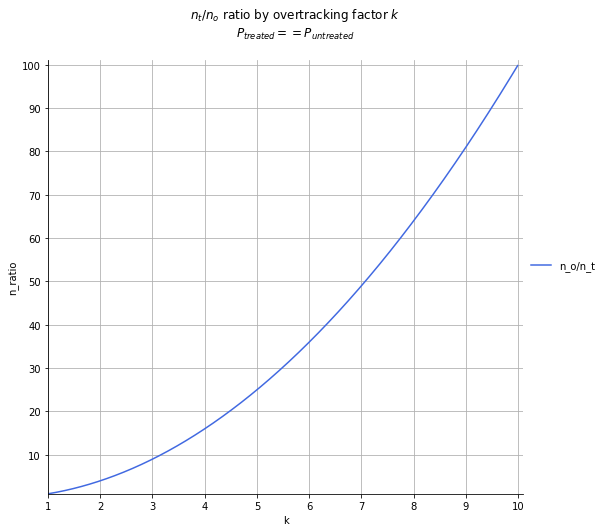

In [6]:
df_plot = df[(df['P_u'] == 0.5) & (df['P_t'] == 0.5)]
g = sns.FacetGrid(data = df_plot.sort_values(by='k'),
                  height=7.5, aspect=1, 
                 )

g.map(sns.lineplot, 'k', 'n_ratio', color='royalblue', label="n_o/n_t")
g.add_legend()
g.set(
    xticks=[k for k in range(max_k+1)],
    yticks=[k for k in range(int(max(df_plot['n_ratio'])+2)) if np.mod(k,10)==0], 
    xlim=(1,max_k+0.1),
    ylim=(1,int(max(df_plot['n_ratio'])+2)),
)
plt.grid()
plt.subplots_adjust(top=0.88) 
g.fig.suptitle("$n_t/n_o$ ratio by overtracking factor $k$\n$P_{treated} == P_{untreated}$")
plt.savefig('kn_plot.png')

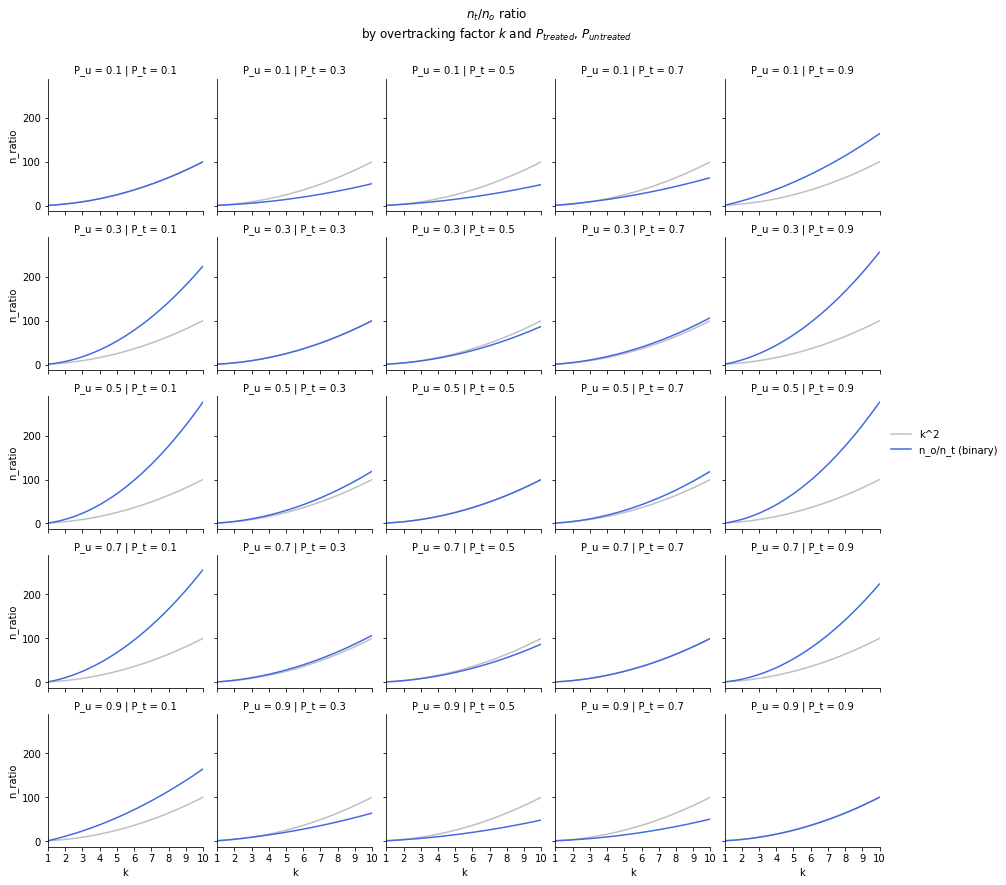

In [7]:
def const_line(*args, **kwargs):
    x = np.arange(1, max_k, .01)
    y = x**2
    plt.plot(x, y, color='gray', alpha=0.5, label='k^2')
    

g = sns.FacetGrid(data = df.sort_values(by='k'),
                  height=2.5, aspect=1, 
                  col='P_t', row='P_u', 
                 )
g.map(const_line)
g.map(sns.lineplot, 'k', 'n_ratio', color='royalblue', label="n_o/n_t (binary)")
g.add_legend()
g.set(
    xticks=[k for k in range(max_k+1)], 
    xlim=(1,max_k)
)
plt.subplots_adjust(top=0.9) 
g.fig.suptitle("$n_t/n_o$ ratio \nby overtracking factor $k$ and $P_{treated}$, $P_{untreated}$")
plt.savefig('u_t_plot.png')

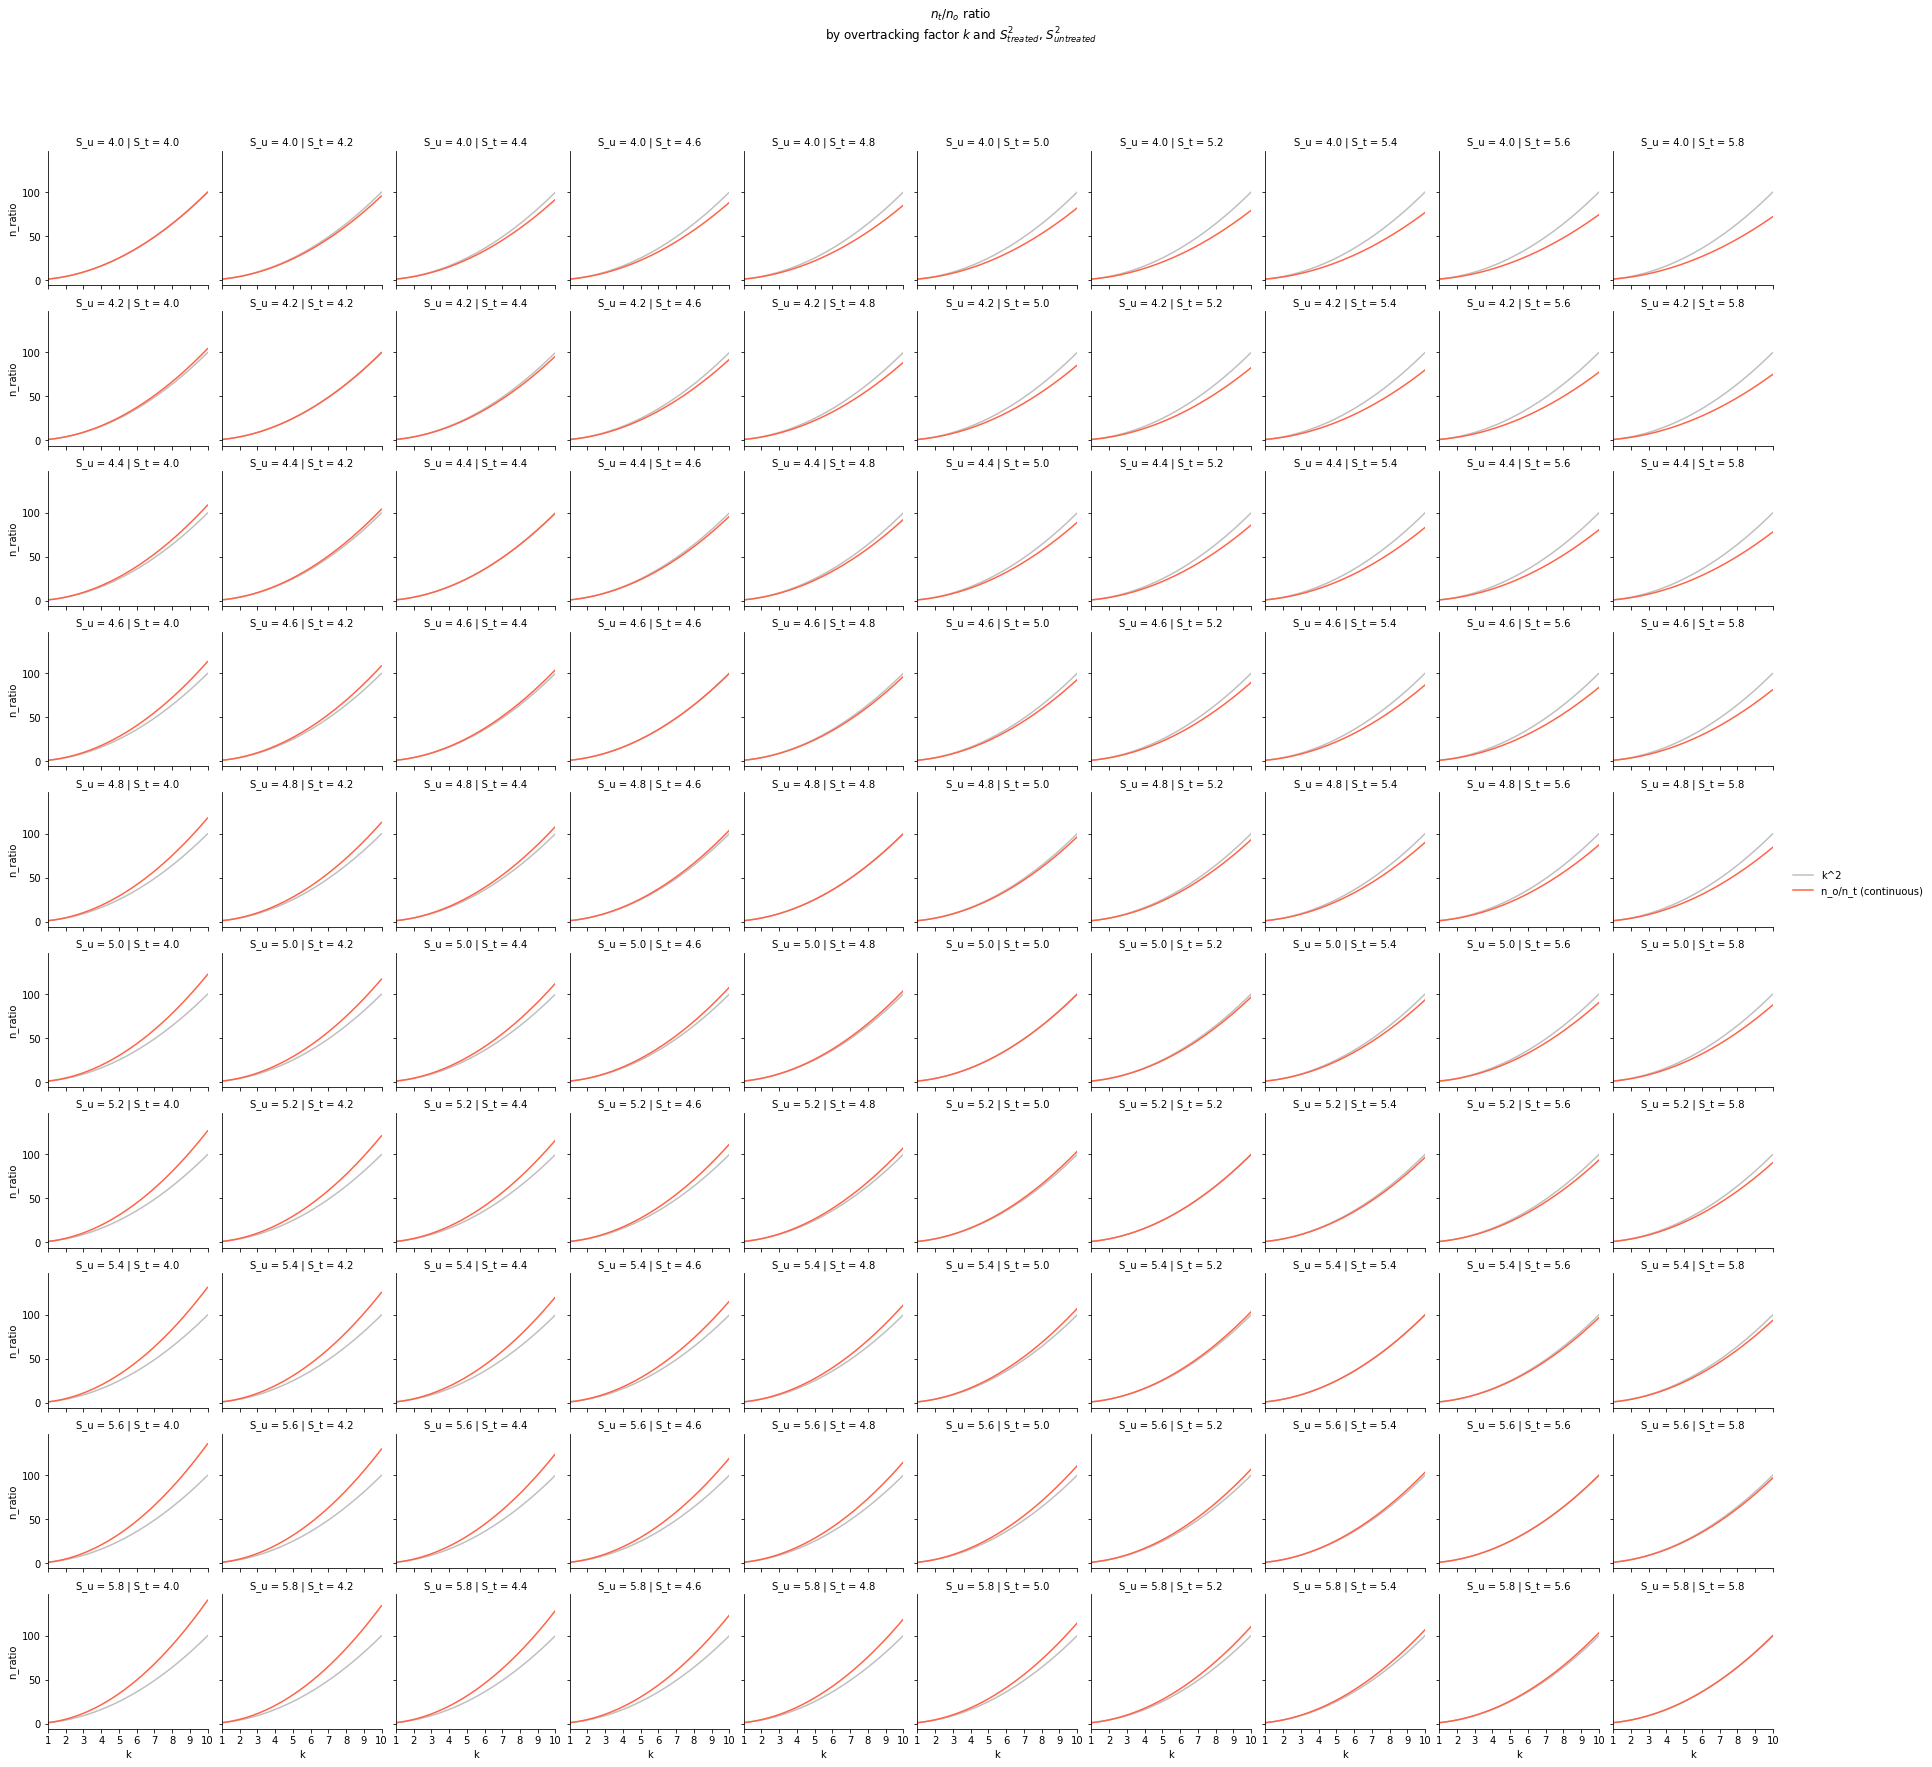

In [8]:
def const_line(*args, **kwargs):
    x = np.arange(1, max_k, .01)
    y = x**2
    plt.plot(x, y, color='gray', alpha=0.5, label='k^2')
    

g = sns.FacetGrid(data = df_cont.sort_values(by='k'),
                  height=2.5, aspect=1, 
                  col='S_t', row='S_u', 
                 )
g.map(const_line)
g.map(sns.lineplot, 'k', 'n_ratio', color='tomato', label="n_o/n_t (continuous)")
g.add_legend()
g.set(
    xticks=[k for k in range(max_k+1)], 
    xlim=(1,max_k)
)
plt.subplots_adjust(top=0.9) 
g.fig.suptitle("$n_t/n_o$ ratio \nby overtracking factor $k$ and $S^{2}_{treated}$, $S^{2}_{untreated}$")
plt.savefig('u_t_plot.png')

In [339]:
### Simulations
sample_size = 10000
n_trials = 100000
p_u = 0.05
p_t_b = 0.05
p_t_v = 0.051

sample_untreated = np.random.binomial(n=n_trials, p=p_u, size=sample_size)
sample_treated_base = np.random.binomial(n=n_trials, p=p_t_b, size=sample_size)
sample_treated_variant = np.random.binomial(n=n_trials, p=p_t_v, size=sample_size)

# sample_untreated = np.random.normal(10, 1, size=sample_size)
# sample_treated_base = np.random.normal(10.1, 1, size=sample_size)
# sample_treated_variant = np.random.normal(10.2, 1, size=sample_size)

In [337]:

ttest_ind(sample_treated_base, sample_treated_variant, equal_var=False)

Ttest_indResult(statistic=-17.41375743726533, pvalue=7.283236438378132e-68)

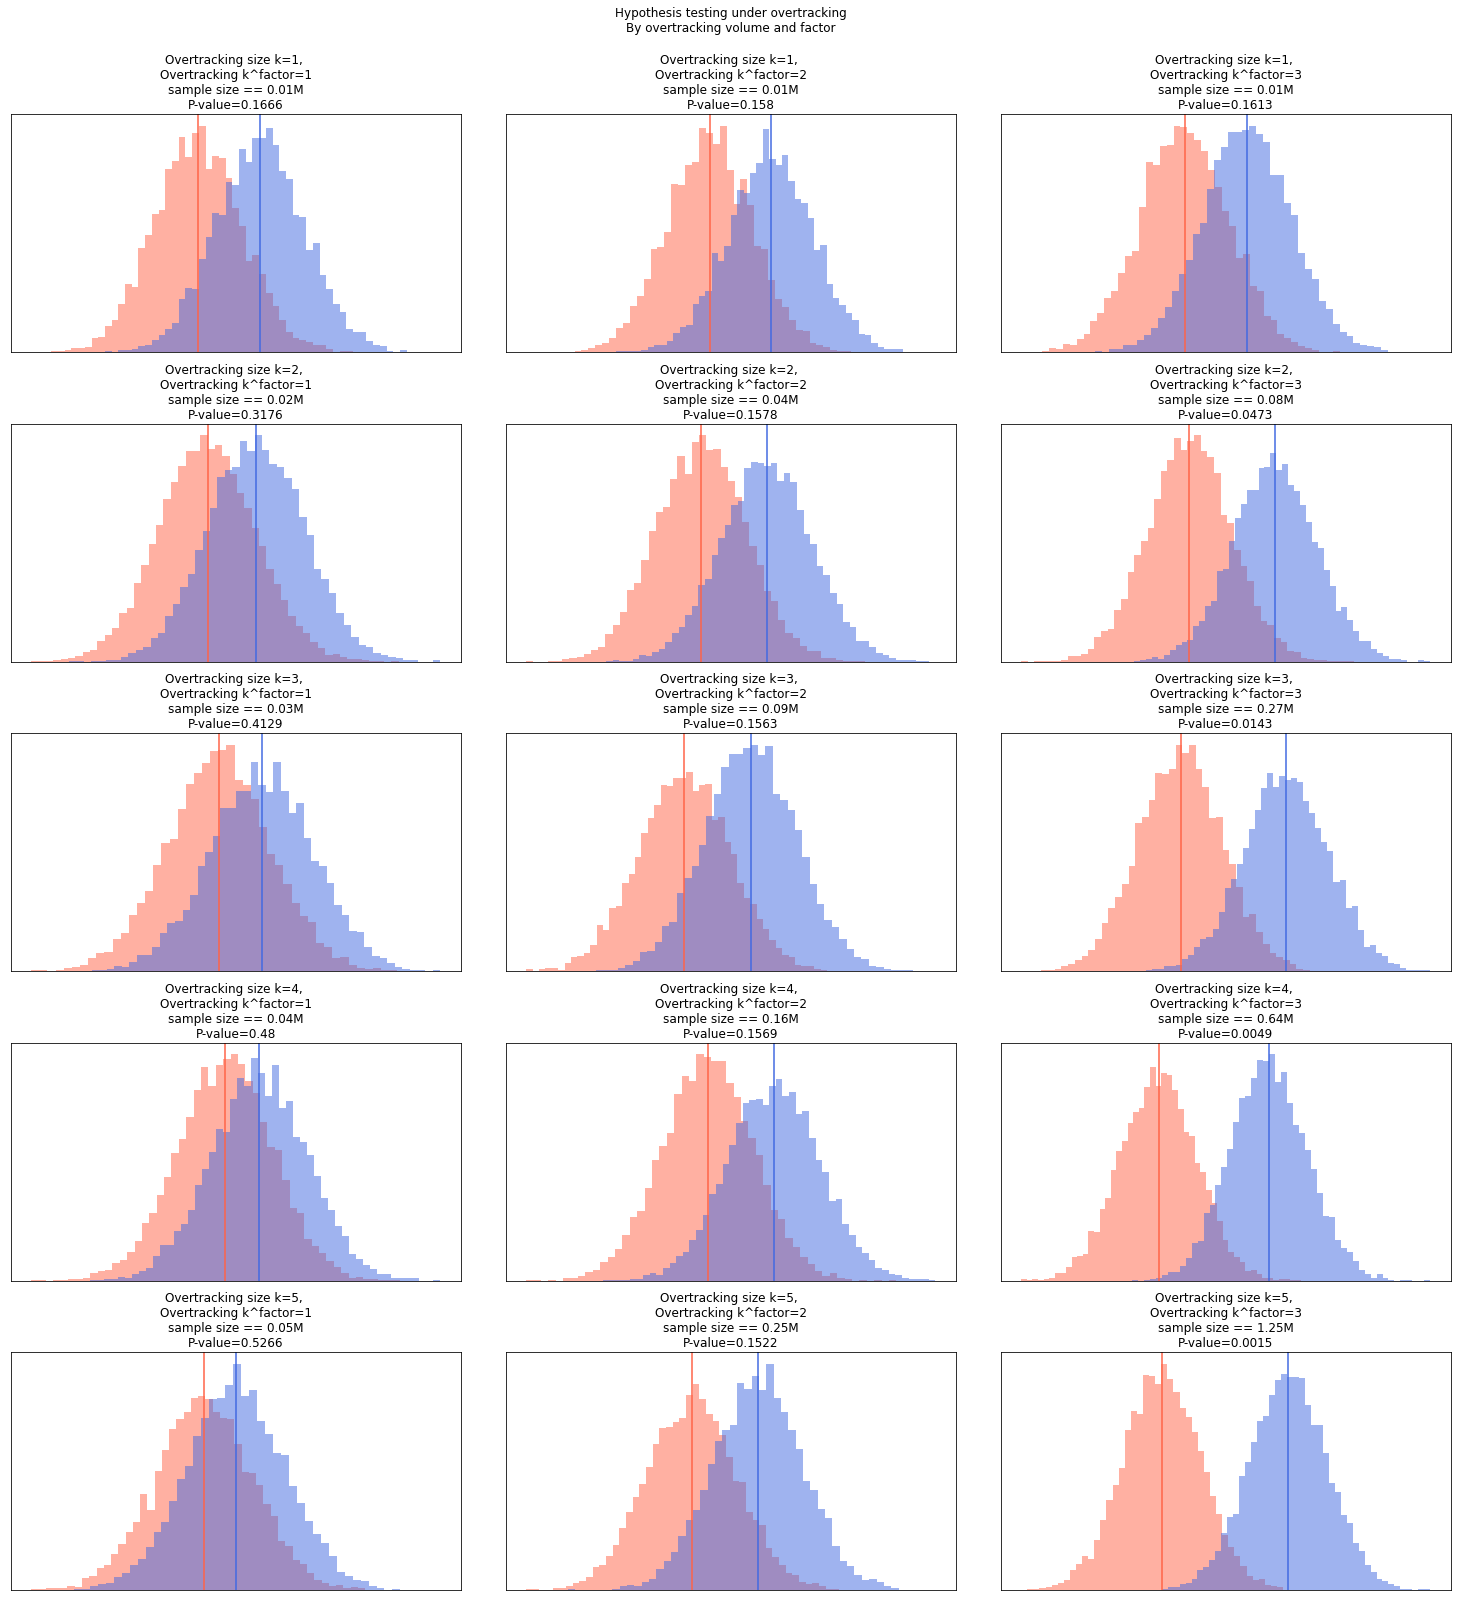

In [347]:
fig, ax = plt.subplots(5,3,figsize=(25,25))
plt.subplots_adjust(
    left=0.1, 
    right=0.9, 
    bottom=0.1,
    top=0.92, 
    wspace=0.1, 
    hspace=0.3
)

np.random.seed(1)
for k_factor in range(1,4):
    for k in range(1,6):
#         sample_treated_base_o = np.random.normal(10.1, 1, size=sample_size)
#         sample_treated_variant_o = np.random.normal(10.2, 1, size=sample_size)
        
        sample_treated_base_o = np.random.binomial(n=n_trials*k**k_factor, p=(p_t_b + (k-1)*p_u)/k, size=sample_size)
        sample_treated_variant_o = np.random.binomial(n=n_trials*k**k_factor, p=(p_t_v + (k-1)*p_u)/k, size=sample_size)
        pval = get_g_test(
            counts_base=sample_treated_base_o.mean(), 
            counts_var=sample_treated_variant_o.mean(), 
            visitors_base=(sample_size*k**k_factor),
            visitors_var=(sample_size*k**k_factor),
        )  
#         pval = ttest_ind(sample_treated_base_o, sample_treated_variant_o, equal_var=False)[1]
        ax[k-1,k_factor-1].hist(sample_treated_base_o, bins=50, alpha=0.5, color='tomato')
        ax[k-1,k_factor-1].hist(sample_treated_variant_o, bins=50, alpha=0.5, color='royalblue')
        ax[k-1,k_factor-1].axvline(x=sample_treated_base_o.mean(), color='tomato')
        ax[k-1,k_factor-1].axvline(x=sample_treated_variant_o.mean(), color='royalblue')
        ax[k-1,k_factor-1].set_title(f'Overtracking size k={k}, \nOvertracking k^factor={k_factor}\nsample size == {((sample_size*(k**k_factor))/1000000)}M\nP-value={np.round(pval,4)}')
        ax[k-1,k_factor-1].set_xticks([])
        ax[k-1,k_factor-1].set_yticks([])
        
fig.suptitle('Hypothesis testing under overtracking\nBy overtracking volume and factor')
plt.savefig('dist_plot.png')

In [368]:
### Simulations
sample_size = 1000
n_trials = 1
p_u = 0.5
p_t_b = 0.5
p_t_v = 0.54

sample_untreated = np.random.binomial(n=n_trials, p=p_u, size=sample_size)
sample_treated_base = np.random.binomial(n=n_trials, p=p_t_b, size=sample_size)
sample_treated_variant = np.random.binomial(n=n_trials, p=p_t_v, size=sample_size)

In [371]:
def get_pval_per_k(k,k_factor, n_trials=n_trials, p_t_b=p_t_b , p_t_v=p_t_v, p_u=p_u, sample_size=sample_size):
    sample_size_o = int(sample_size*(k**k_factor))
    sample_treated_base_o = np.random.binomial(n=n_trials, p=(p_t_b + (k-1)*p_u)/k, size=sample_size_o)
    sample_treated_variant_o = np.random.binomial(n=n_trials, p=(p_t_v + (k-1)*p_u)/k, size=sample_size_o)
    p_val = get_g_test(counts_base=sample_treated_base_o.sum(), 
           counts_var=sample_treated_variant_o.sum(), 
           visitors_base=sample_size_o,
           visitors_var=sample_size_o)
    
    return p_val  

In [372]:
k_vals = [k/10 for k in range(10,70,1)]
k_factor_vals = [k_factor/10 for k_factor in range(10,50,10)]
bootstraps = [i for i in range(100)]

shape_df = len(k_factor_vals)*len(k_vals)*len(bootstraps)

In [373]:
df = pd.DataFrame([i for i in product(bootstraps,k_factor_vals, k_vals)])
df.columns = ['bootstrap','k_factor','k']
df

,bootstrap,k_factor,k
0,0,1.0,1.0
1,0,1.0,1.1
2,0,1.0,1.2
3,0,1.0,1.3
4,0,1.0,1.4
...,...,...,...
23995,99,4.0,6.5
23996,99,4.0,6.6
23997,99,4.0,6.7
23998,99,4.0,6.8


In [ ]:
%timeit df['p_val'] = df.apply(lambda x: get_pval_per_k(x['k'],x['k_factor']), axis=1)
df

In [ ]:
g = sns.FacetGrid(data = df.reset_index(),
                  height=7.5, aspect=3, 
                  hue='k_factor', palette='coolwarm'
                 )
g.map(sns.lineplot, 'k', 'p_val')
g.add_legend()
# g.set(
#     xticks=[k for k in range(max_k+1)],
#     yticks=[k for k in range(int(max(df_plot['n_ratio'])+2)) if np.mod(k,10)==0], 
#     xlim=(1,max_k+0.1),
#     ylim=(1,int(max(df_plot['n_ratio'])+2)),
# )
# plt.grid()
plt.subplots_adjust(top=0.92) 
g.fig.suptitle(f"Hypothesis testing (p-values for rejecting the null hypothesis: $H_0 = \mu_0 == \mu_1$) under overtracking\nBy overtracking volume and factor\nSampling with {len(bootstraps)} bootstraps")
plt.savefig('pval_plot.png')